Оглавление:
- [Получаем данные](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=DPJulx9cVe2N&line=1&uniqifier=1)
- [Дорабатываем данные](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=RRs-21c7AGYt&line=1&uniqifier=1)
- [Анализ](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=l3pqLPTWVpxd&line=1&uniqifier=1)
    - [KPI по дням](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=UgB3H3U9EOhL&line=1&uniqifier=1)
    - [KPI по неделям](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=Ov8golj2V2s2&line=1&uniqifier=1)
    - [KPI по месяцам](https://colab.research.google.com/drive/18qk2ciWrKjEfBlv5CK-6MvMOgEYzC5DI#scrollTo=x8xT_W2EVddL&line=1&uniqifier=1)

## Получаем данные

In [2]:
! pip3 install clickhouse-driver[lz4] -q

     |████████████████████████████████| 604kB 4.3MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 1.8MB 25.9MB/s 


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from clickhouse_driver import Client
import pandas as pd
import numpy as np

In [4]:
client = Client('dev-01.aksimemor.me', database = "default", user ="thanos", password ="show_me_your_data")

In [5]:
query = 'select DISTINCT user_id,created_at, reporting_revenue from marvel'
result = client.execute(query)


In [6]:
result[1]

(UUID('a874576a-26b6-2ed6-0000-52267e2ea0bf'),
 datetime.datetime(2020, 6, 14, 12, 35, 10),
 0.0)

## Дорабатываем данные в Python

In [7]:
df = pd.DataFrame(result)

In [8]:
df.columns = ['UUID', 'created_at','reporting_revenue']

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

UUID                 0
created_at           0
reporting_revenue    0
dtype: int64

In [11]:
first_visit = df.groupby('UUID')['created_at'].min().reset_index()
first_visit.columns = ['UUID','first_visit']

In [12]:
df = df.merge(first_visit,on='UUID' , how='left')
df.head()

,UUID,created_at,reporting_revenue,first_visit
0,a874576a-26b6-2ed6-0000-52267e2ea0bf,2020-06-13 07:27:55,0.0,2020-06-13 07:27:55
1,a874576a-26b6-2ed6-0000-52267e2ea0bf,2020-06-14 12:35:10,0.0,2020-06-13 07:27:55
2,56f09403-5d9f-b1d2-0000-65428547f6e3,2020-06-07 16:02:23,0.0,2020-06-07 16:02:23
3,56f09403-5d9f-b1d2-0000-65428547f6e3,2020-06-07 17:33:40,0.0,2020-06-07 16:02:23
4,56f09403-5d9f-b1d2-0000-65428547f6e3,2020-06-07 20:04:20,0.0,2020-06-07 16:02:23


In [13]:
df['activity_month'] = df['created_at'].astype('datetime64[M]')
df['first_activity_month'] = df['first_visit'].astype('datetime64[M]')
df['activity_day'] = df['created_at'].astype('datetime64[D]')
df['first_activity_day'] = df['first_visit'].astype('datetime64[D]')
df['activity_week'] = df['created_at'].astype('datetime64[D]') - pd.to_timedelta(df['created_at'].dt.dayofweek,unit='d')
df['first_activity_week'] = df['first_visit'].astype('datetime64[D]') - pd.to_timedelta(df['first_visit'].dt.dayofweek,unit='d')

## Анализ

**KPI по дням**

In [14]:
df['cohort_lifetime_by_day'] = df['activity_day'] - df['first_activity_day']
cohorts_by_day = df.groupby(['first_activity_day','cohort_lifetime_by_day']).agg({'UUID':'nunique', 'reporting_revenue':'sum'}).reset_index()
initial_amount_by_day = cohorts_by_day[cohorts_by_day['cohort_lifetime_by_day'] == '0'][['first_activity_day','UUID']]
initial_amount_by_day = initial_amount_by_day.rename(columns={'UUID':'cohort_users_by_day'})
cohorts_by_day = cohorts_by_day.merge(initial_amount_by_day, on='first_activity_day', how='left')
cohorts_by_day['retention'] = cohorts_by_day['UUID'] / cohorts_by_day['cohort_users_by_day'] 
retention_pivot_day = cohorts_by_day.pivot_table(index = 'first_activity_day', columns = 'cohort_lifetime_by_day' , values = 'retention', aggfunc='sum' )

In [15]:
cohorts_by_day['ARPU'] = cohorts_by_day['reporting_revenue'] / cohorts_by_day['cohort_users_by_day']


In [16]:
arpu_pivot = cohorts_by_day.pivot_table(index = 'first_activity_day', columns = 'cohort_lifetime_by_day' , values = 'ARPU', aggfunc='sum' )
filtered_arpu_pivot = arpu_pivot[['0 days','1 days','2 days','3 days','4 days', '14 days','28 days', '30 days']]

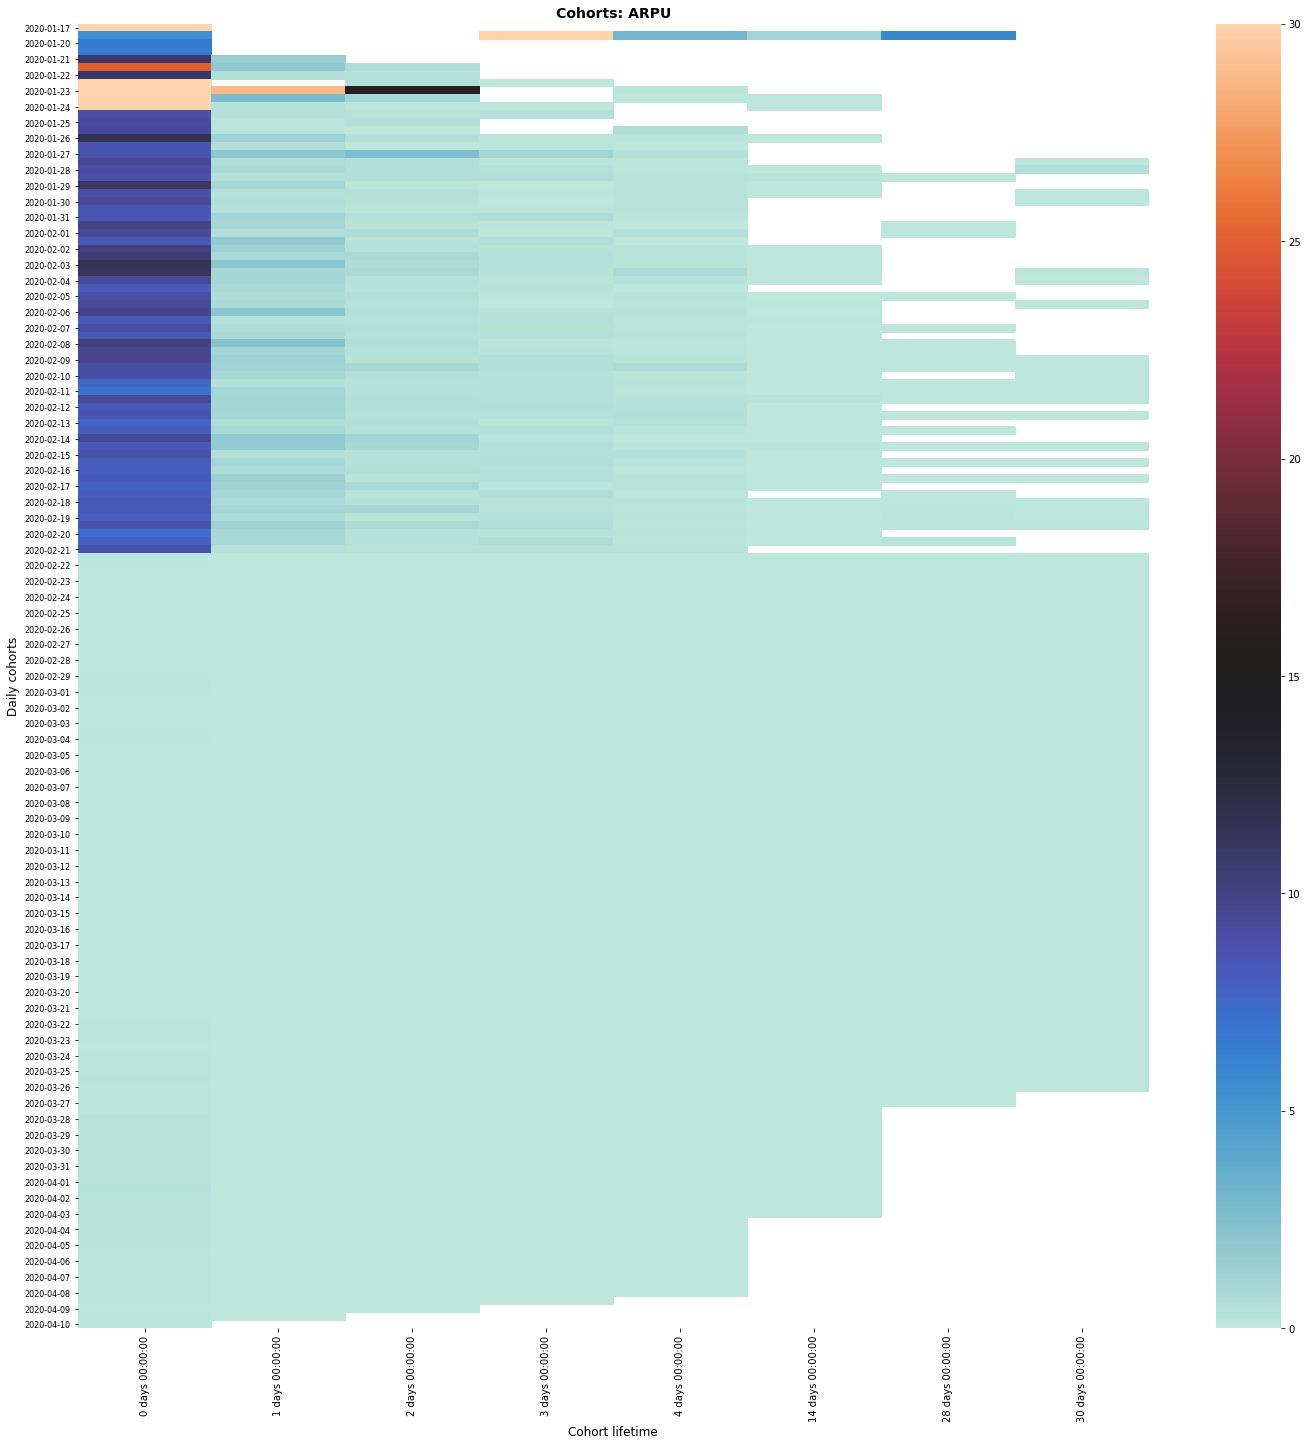

In [24]:
plt.figure(figsize=(24, 24))
fig = sns.heatmap(filtered_arpu_pivot, cmap='icefire', vmax= 30)
fig.set_yticklabels(filtered_arpu_pivot.index.strftime('%Y-%m-%d'), fontsize = 8)
fig.set_xticklabels(filtered_arpu_pivot.T.index)
fig.set_title('Cohorts: ARPU', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('Daily cohorts', fontsize='12');

In [18]:
filtered_retention_pivot_day = retention_pivot_day[['0 days','1 days','2 days','3 days','4 days', '14 days','28 days', '30 days']]

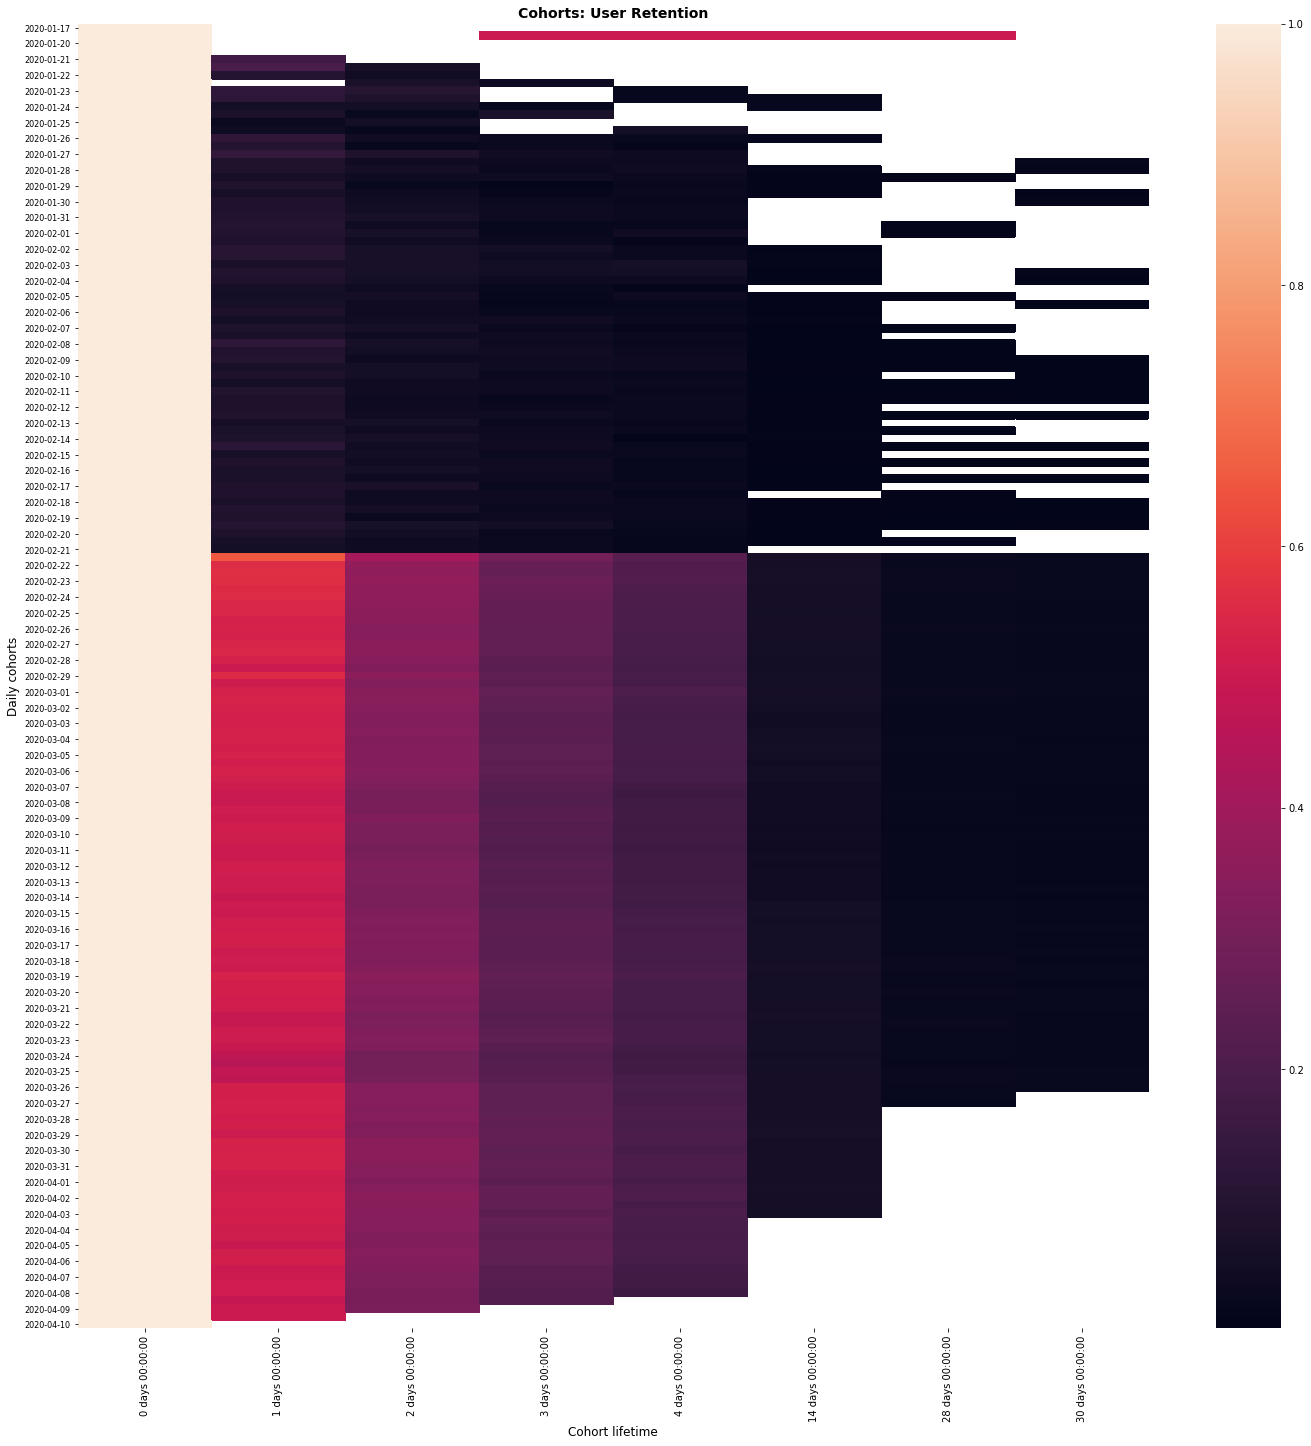

In [19]:
plt.figure(figsize=(24, 24))
fig = sns.heatmap(filtered_retention_pivot_day)
fig.set_yticklabels(filtered_retention_pivot_day.index.strftime('%Y-%m-%d'), fontsize = 8)
fig.set_xticklabels(filtered_retention_pivot_day)
fig.set_title('Cohorts: User Retention', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('Daily cohorts', fontsize='12');

**Вывод:**

1) ARPU
 - Мы видим, что когорта 20-01-2020 выделяется ARPU на 3 день, что скорее всего является выборосом или может объясняться тем, что это высокоплатящий пользователь.
 - Для когорт с 17-01-2020 по 21-02-2020 APRU 0 дня выше, чем последующих когорт, возможно в последующих когортах изменилась страктура пользователей или в игру было внесено изменение, которое перестало требовать покупок в 0 день.

2) Retention
 - Первая когорта должна быть исколючена из анализа из-за небольшого количетсва данных (1 пользователь)
 - Мы видим, что начиная с когорты 21-02-2020 было внесено изменение, которое улучшило retention 1-4 дня. 


Примечание: Я оставил на графиках только 0,1,2,3,4, 14, 28 и 30 дни, т.к.retention по этим периодам более важен для анализа. Сам вид графиков мне не очень нравится, но я не придумал как сделать более показательным

**KPI по неделям**

In [25]:
df['cohort_lifetime_week'] = df['activity_week'] - df['first_activity_week']
df['cohort_lifetime_week'] = (df['cohort_lifetime_week'] / np.timedelta64(1, 'W')).astype(int)
cohorts_by_week = df.groupby(['first_activity_week','cohort_lifetime_week']).agg({'UUID':'nunique', 'reporting_revenue':'sum'}).reset_index()
initial_amount_by_week = cohorts_by_week[cohorts_by_week['cohort_lifetime_week'] == 0][['first_activity_week','UUID']]
initial_amount_by_week = initial_amount_by_week.rename(columns={'UUID':'cohort_users'})
cohorts_by_week = cohorts_by_week.merge(initial_amount_by_week, how='left',on='first_activity_week')
cohorts_by_week['retention'] = cohorts_by_week['UUID'] / cohorts_by_week['cohort_users']
retention_pivot_week = cohorts_by_week.pivot_table(index = 'first_activity_week', columns = 'cohort_lifetime_week' , values = 'retention', aggfunc='sum' )

In [26]:
cohorts_by_week['ARPU'] = cohorts_by_week['reporting_revenue'] / cohorts_by_week['cohort_users']
arpu_pivot_by_week = cohorts_by_week.pivot_table(index = 'first_activity_week', columns = 'cohort_lifetime_week' , values = 'ARPU', aggfunc='sum' )

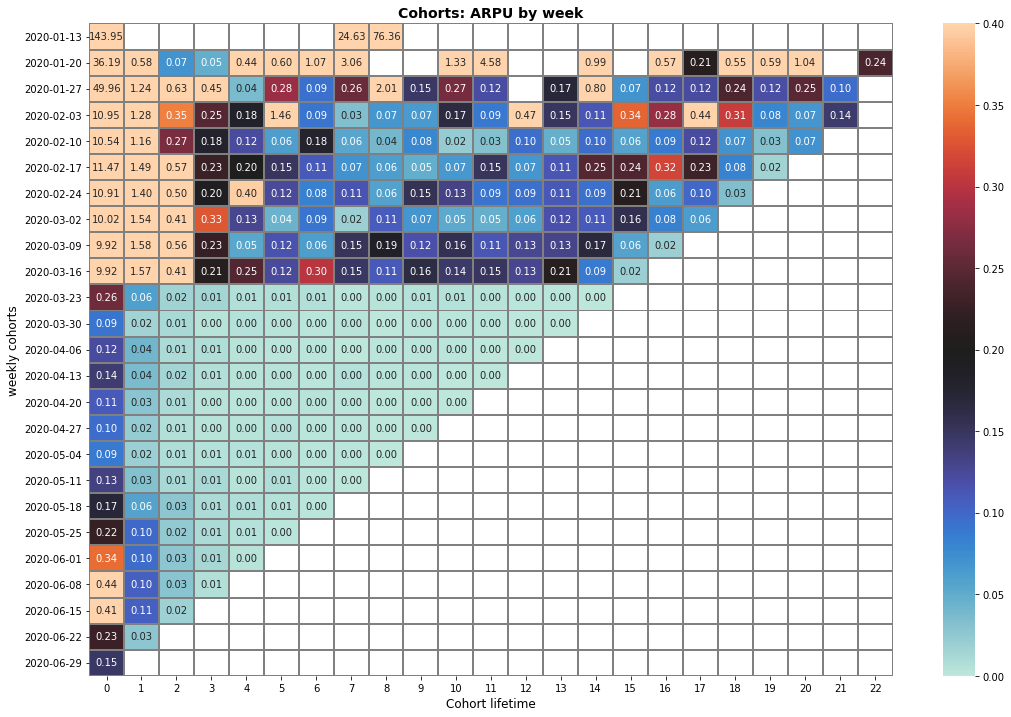

In [28]:
plt.figure(figsize=(18, 12))
fig = sns.heatmap(arpu_pivot_by_week, annot=True, fmt='.2f', linewidths=1, linecolor='gray',  cmap='icefire', vmax= 0.4, vmin=0) 
fig.set_yticklabels(arpu_pivot_by_week.index.strftime('%Y-%m-%d'))
fig.set_title('Cohorts: ARPU by week', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('weekly cohorts', fontsize='12');

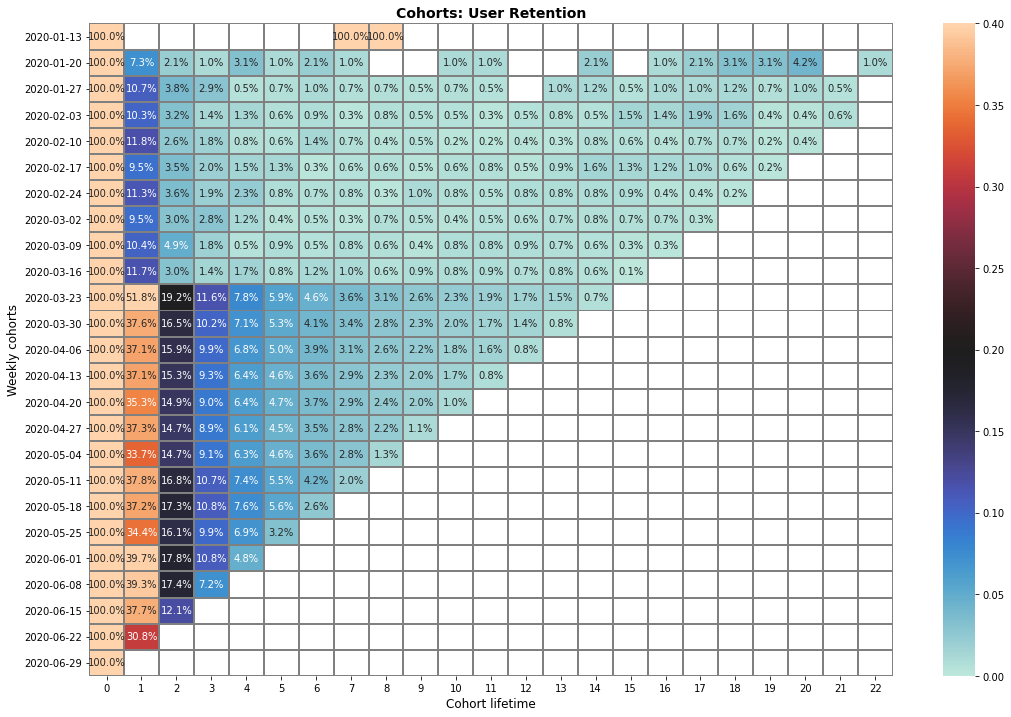

In [29]:
plt.figure(figsize=(18, 12))
fig = sns.heatmap(retention_pivot_week, annot=True, fmt='.1%', linewidths=1, linecolor='gray',  cmap='icefire', vmax= 0.4, vmin=0) 
fig.set_yticklabels(retention_pivot_week.index.strftime('%Y-%m-%d'))
fig.set_title('Cohorts: User Retention', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('Weekly cohorts', fontsize='12');

**Вывод:**

1) ARPU
Аналогичный тренд, которые наблюдался на уровне анализа по дням - первые когорты характеризуются более высоким APRU на первых неделях жизни.

2) Retention
В целом, мы видим тренд на снижение уровня retention для последних когорт - 5% на 4 неделе для когорты 01-06-2020 в сравнении с 7% для аналогичного периода когорты 25-05-2020


**KPI по месяцам**

In [30]:
df['cohort_lifetime'] = df['activity_month'] - df['first_activity_month']
df['cohort_lifetime'] = (df['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype(int)
cohorts = df.groupby(['first_activity_month','cohort_lifetime']).agg({'UUID':'nunique','reporting_revenue':'sum' }).reset_index()
initial_amount = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','UUID']]
initial_amount = initial_amount.rename(columns={'UUID':'cohort_users'})
cohorts = cohorts.merge(initial_amount, on='first_activity_month')
cohorts['retention'] = cohorts['UUID'] / cohorts['cohort_users'] 
retention_pivot_month = cohorts.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime' , values = 'retention', aggfunc='sum' )

In [31]:
cohorts['ARPU'] = cohorts['reporting_revenue'] / cohorts['cohort_users']
arpu_pivot_by_month = cohorts.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime' , values = 'ARPU', aggfunc='sum' )

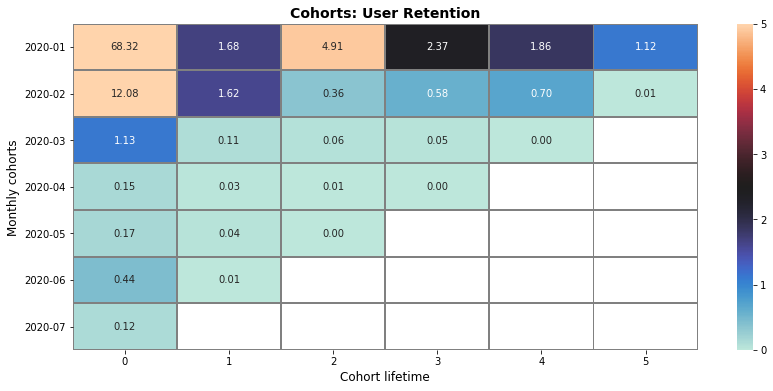

In [35]:
plt.figure(figsize=(14, 6))
fig = sns.heatmap(arpu_pivot_by_month, annot=True, fmt='.2f', linewidths=1, linecolor='gray',  cmap='icefire', vmax= 5, vmin=0) 
fig.set_yticklabels(arpu_pivot_by_month.index.strftime('%Y-%m'))
fig.set_title('Cohorts: User Retention', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('Monthly cohorts', fontsize='12');

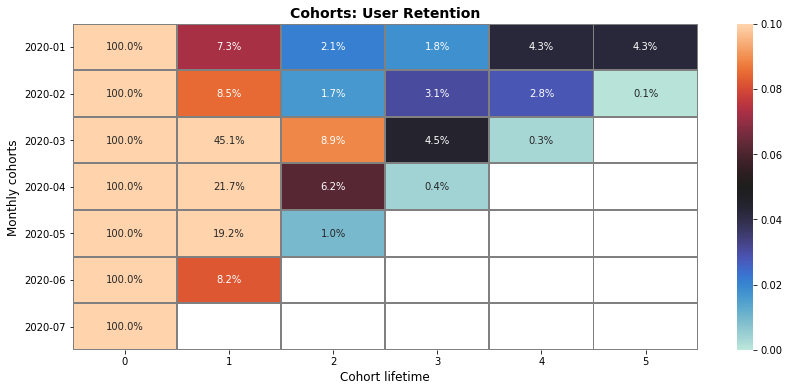

In [38]:
plt.figure(figsize=(14, 6))
fig = sns.heatmap(retention_pivot_month, annot=True, fmt='.1%', linewidths=1, linecolor='gray',  cmap='icefire', vmax= 0.1, vmin=0) 
fig.set_yticklabels(retention_pivot_month.index.strftime('%Y-%m'))
fig.set_title('Cohorts: User Retention', weight='bold', fontsize='14')
fig.set_xlabel('Cohort lifetime', fontsize='12')
fig.set_ylabel('Monthly cohorts', fontsize='12');

**Вывод:**
 
1) ARPU:
 - Мы видим, что в январской когорте есть аномалия в виде высокого ARPU на 3 месяце жизни этой когорты. В других когортах такого эффекта не наблюдается

2) Retention:
 - Когорта Март'20 демонстрирует более высокий уровень retention по сравнению с другими когортами на 1,2 и 3 месяце жизни этой когорты